In [6]:
import os, glob
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
from typing import List

In [7]:
def compute_accuracy(preds_df, gold_column, pred_column):
    return preds_df.groupby('language')[[gold_column, pred_column]]\
        .apply(lambda x: (x[gold_column] == x[pred_column])\
               .mean())\
                .reset_index()\
                    .rename(columns={0: 'accuracy'})

In [8]:
def plot(df):
    topics = df.index
    languages = df.columns
    x = np.arange(len(topics))  # label locations
    width = 0.2  # bar width

    fig, ax = plt.subplots(figsize=(12, 6))
    colors = {'de': 'indianred', 'fr': 'royalblue', 'it': 'seagreen'}

    # Plot bars for each language
    for i, lang in enumerate(languages):
        ax.bar(x + i * width, df[lang], width, color=colors[lang], label=lang)

    ax.set_xlabel("Topic")
    ax.set_ylabel("Accuracy")
    ax.set_title("Performance by Topic and Language")
    ax.set_xticks(x + width, topics, rotation=45, ha="right")
    ax.legend(loc='upper center', ncol=len(languages))
    ax.grid(axis="y", linestyle="--", alpha=0.7)

    plt.tight_layout()
    plt.show()

In [9]:
def plot_metrics(model_dir):
    last_ckpt = os.path.join(glob.glob(os.path.join(model_dir, 'checkpoint-*'))[-1], 'trainer_state.json')

    with open(last_ckpt, 'r') as file:
        data = json.load(file)

    log_history = (pd.DataFrame(data['log_history'])
                .groupby("epoch")
                .agg(lambda x: x.dropna().iloc[0] if not x.dropna().empty else None)
                .reset_index())
    
    log_history.plot(x='epoch', 
                     y=['eval_accuracy', 'eval_loss', 'loss'], 
                     label=['Validation Accuracy', 'Validation Loss', 'Training Loss'], 
                     color=['green', 'red', 'maroon'], 
                     grid=True
                     )

In [10]:
def analyze_errors(df):
    incorrect_preds = df.query("label != prediction")

    # Compute FP and FN by language
    result = incorrect_preds.groupby('language')['prediction'].agg(
        FP=lambda x: round((x == 'FAVOR').sum() / len(x) * 100, 2),  # (AGAINST → FAVOR)
        FN=lambda x: round((x == 'AGAINST').sum() / len(x) * 100, 2),  # (FAVOR → AGAINST)
        ).reset_index().rename(columns={'FP': 'FP (%)', 'FN': 'FN (%)'})

    return result

In [11]:
def balance_df(df, columns:List, rs=42):
    # minimum count of rows for any combination of values in the specified columns
    min_count = df.groupby(columns).size().min()
    
    # sample min_count rows for each column combination
    balanced_df = (
        df.groupby(columns)
          .apply(lambda group: group.sample(min_count, random_state=rs))
          .reset_index(drop=True)
    )
    
    return balanced_df.sample(frac=1).reset_index(drop=True)    # shuffle the rows

---

## Determining Topic Controversy in the Dataset

<Axes: title={'center': 'Number of Questions per Topic'}, ylabel='topic'>

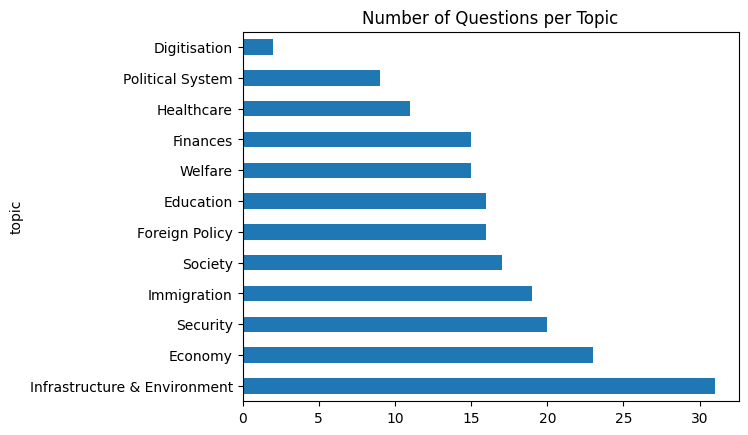

In [12]:
questions_en = pd.read_json('../../data/xstance/questions.en.jsonl', lines=True)
questions_en['topic'].value_counts().plot(kind='barh', title='Number of Questions per Topic')

<Axes: title={'center': 'Number of Comments per Topic'}, ylabel='topic'>

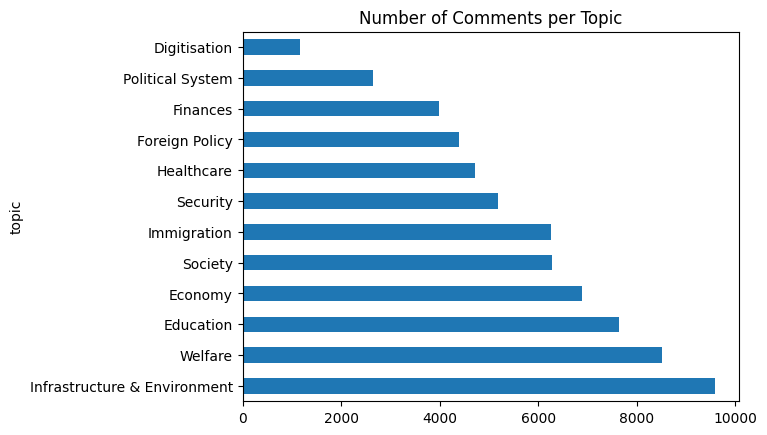

In [13]:
train = pd.read_json('../../data/xstance/train.jsonl', lines=True)
valid = pd.read_json('../../data/xstance/valid.jsonl', lines=True)
test = pd.read_json('../../data/xstance/test.jsonl', lines=True)
all_data = pd.concat([train, valid, test])
all_data['topic'].value_counts().plot(kind='barh', title='Number of Comments per Topic')

<Axes: title={'center': 'Topic Controversy'}, ylabel='topic'>

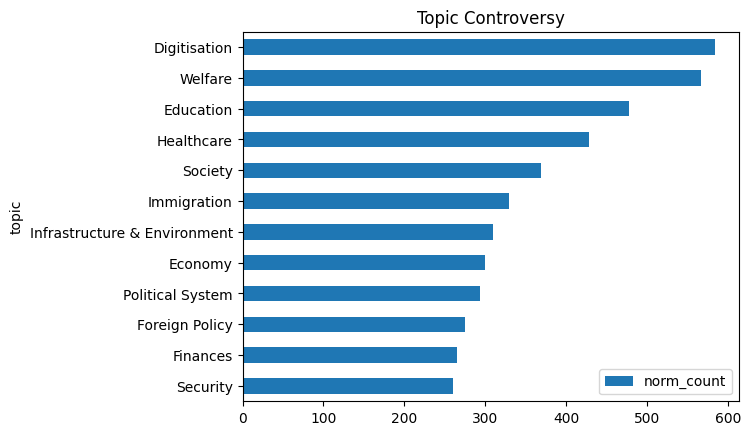

In [14]:
topic_q_counts = questions_en['topic'].value_counts().reset_index().rename(columns={'count': 'q_count'})
topic_cm_counts = all_data['topic'].value_counts().reset_index().rename(columns={'count': 'cm_count'})
topic_norm_counts = pd.merge(topic_q_counts, topic_cm_counts, on='topic').assign(norm_count=lambda x: round(x['cm_count'] / x['q_count'], 2)).sort_values('norm_count')
topic_norm_counts.plot(kind='barh', x='topic', y='norm_count', title='Topic Controversy')

In [15]:
all_data.groupby(['question_id', 'topic']).agg(
    n_FAVOR=('label', lambda x: (x == 'FAVOR').sum()),
    n_AGAINST = ('label', lambda x : (x == 'AGAINST').sum())
).reset_index()

,question_id,topic,n_FAVOR,n_AGAINST
0,2,Welfare,303,120
1,4,Welfare,144,128
2,6,Welfare,121,179
3,7,Healthcare,198,157
4,9,Healthcare,118,110
...,...,...,...,...
189,3464,Security,173,105
190,3468,Foreign Policy,138,311
191,3469,Foreign Policy,209,162
192,3470,Foreign Policy,246,189


---
## Binary

### Baseline

In [16]:
bi_baseline_preds = pd.read_csv('../../predictions/bi_baseline_preds.csv')
bi_baseline_acc = compute_accuracy(bi_baseline_preds, 'label', 'prediction')

### Fine-tuned

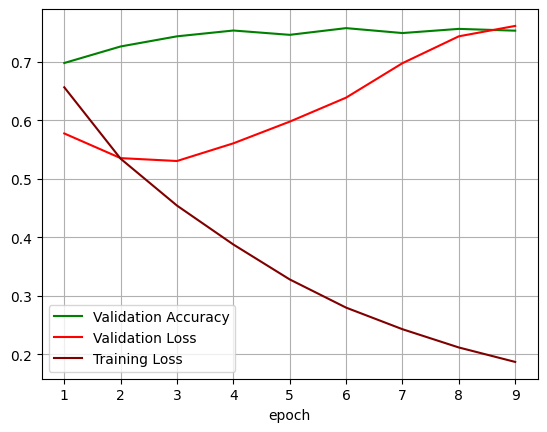

In [17]:
model_dir = "../../models/binary_stance_classifier/"
plot_metrics(model_dir)

In [18]:
# Only comments
# test_preds = pd.read_csv('../../predictions/xstance_test_preds_finetuned.csv')
# compute_accuracy(test_preds, 'label', 'prediction')

In [19]:
# Questions + comments
bi_test_preds = pd.read_csv('../../predictions/bi_test_preds.csv')
bi_ft_acc = compute_accuracy(bi_test_preds, 'label', 'prediction')

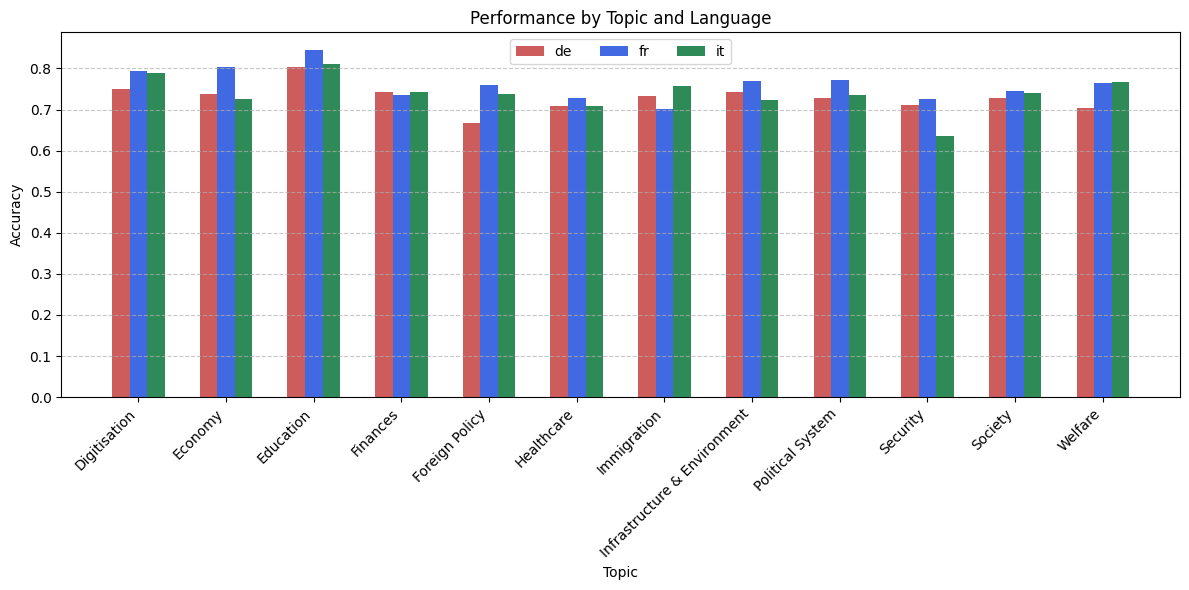

In [20]:
bi_test_preds_by_topics = bi_test_preds.groupby(['topic', 'language'])[['label', 'prediction']]\
    .apply(lambda x: (x['label'] == x['prediction']).mean())\
    .reset_index()\
    .pivot(index='topic', columns='language', values=0)

plot(bi_test_preds_by_topics)

### Translated

In [21]:
de2fr_preds = pd.read_csv('../../predictions/de2fr_preds.csv')
de2fr_acc = compute_accuracy(de2fr_preds, 'label', 'prediction').assign(trans_description='German → French')

fr2de_preds = pd.read_csv('../../predictions/fr2de_preds.csv')
fr2de_acc = compute_accuracy(fr2de_preds, 'label', 'prediction').assign(trans_description='French → German')

it2fr_preds = pd.read_csv('../../predictions/it2fr_preds.csv')
it2fr_acc = compute_accuracy(it2fr_preds, 'label', 'prediction').assign(trans_description='Italian → French')

it2de_preds = pd.read_csv('../../predictions/it2de_preds.csv')
it2de_acc = compute_accuracy(it2de_preds, 'label', 'prediction').assign(trans_description='Italian → German')

translated_acc = pd.concat([de2fr_acc, fr2de_acc, it2fr_acc, it2de_acc]).reset_index(drop=True)

In [22]:
# All accuracies

bi_acc = reduce(lambda left, right: pd.merge(left, right, on='language'), [
    bi_baseline_acc.rename(columns={'accuracy': 'acc_baseline'}),
    bi_ft_acc.rename(columns={'accuracy': 'acc_finetuned'}),
    translated_acc.rename(columns={'accuracy': 'acc_translated'}),
])

bi_acc

,language,acc_baseline,acc_finetuned,acc_translated,trans_description
0,de,0.494660,0.726095,0.671516,German → French
1,fr,0.456502,0.755037,0.691392,French → German
2,it,0.460581,0.737206,0.716459,Italian → French
3,it,0.460581,0.737206,0.699170,Italian → German


### Error Analysis
**Question:** How many times has the stance changed and in which direction?

In [23]:
analyze_errors(bi_test_preds)

,language,FP (%),FN (%)
0,de,45.41,54.59
1,fr,38.97,61.03
2,it,44.74,55.26


In [24]:
de2fr_err = analyze_errors(de2fr_preds).assign(trans_description='German → French')
fr2de_err = analyze_errors(fr2de_preds).assign(trans_description='French → German')
it2fr_err = analyze_errors(it2fr_preds).assign(trans_description='Italian → French')
it2de_err = analyze_errors(it2de_preds).assign(trans_description='Italian → German')

trans_err = pd.concat([de2fr_err, fr2de_err, it2fr_err, it2de_err]).reset_index(drop=True)
trans_err

,language,FP (%),FN (%),trans_description
0,de,42.83,57.17,German → French
1,fr,47.11,52.89,French → German
2,it,40.00,60.00,Italian → French
3,it,45.06,54.94,Italian → German


In [25]:
bi_test_preds.groupby(['question_id', 'topic']).agg(
    TP=('label', lambda x: ((x == 'FAVOR') & (bi_test_preds.loc[x.index, 'prediction'] == 'FAVOR')).sum()),
    TN=('label', lambda x: ((x == 'AGAINST') & (bi_test_preds.loc[x.index, 'prediction'] == 'AGAINST')).sum()),
    FP=('label', lambda x: ((x == 'AGAINST') & (bi_test_preds.loc[x.index, 'prediction'] == 'FAVOR')).sum()),
    FN=('label', lambda x: ((x == 'FAVOR') & (bi_test_preds.loc[x.index, 'prediction'] == 'AGAINST')).sum()),
    TotalP=('label', lambda x: (x == 'FAVOR').sum()),
    TotalN=('label', lambda x: (x == 'AGAINST').sum())
).reset_index()

,question_id,topic,TP,TN,FP,FN,TotalP,TotalN
0,2,Welfare,33,7,9,3,36,16
1,4,Welfare,17,10,3,5,22,13
2,6,Welfare,7,12,5,5,12,17
3,7,Healthcare,79,138,19,119,198,157
4,9,Healthcare,88,68,42,30,118,110
...,...,...,...,...,...,...,...,...
179,3464,Security,142,77,28,31,173,105
180,3468,Foreign Policy,7,37,5,8,15,42
181,3469,Foreign Policy,22,17,6,5,27,23
182,3470,Foreign Policy,19,20,6,3,22,26


### Control for Topic

In [26]:
ub_preds = pd.read_csv('../../predictions/ub_preds.csv')
filtered_train = pd.read_json('../../data/xstance/filtered_train.jsonl', lines=True)
ub_preds = ub_preds[ub_preds['topic'].isin(filtered_train['topic'].unique())]


In [27]:
ub_acc = compute_accuracy(ub_preds, 'label', 'prediction')
ub_acc

,language,accuracy
0,de,0.727528
1,fr,0.770563
2,it,0.732438


In [28]:
ub_bal = balance_df(ub_preds, ['language', 'label'])
compute_accuracy(ub_bal, 'label', 'prediction')

/tmp/ipykernel_3900831/2924625210.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: group.sample(min_count, random_state=rs))


,language,accuracy
0,de,0.751136
1,fr,0.770455
2,it,0.732955


In [29]:
inf_env_base = bi_baseline_preds.query('topic == "Infrastructure & Environment"') # "Infrastructure & Environment"
inf_env_base_balanced = balance_df(inf_env_base, ['language', 'label'])
base = compute_accuracy(inf_env_base_balanced, 'label', 'prediction')

inf_env_ft = bi_test_preds.query('topic == "Infrastructure & Environment"')
inf_env_ft_balanced = balance_df(inf_env_ft, ['language', 'label'])
finetuned = compute_accuracy(inf_env_ft_balanced, 'label', 'prediction')

inf_env_ub = ub_preds.query('topic == "Infrastructure & Environment"')
inf_env_ub_bal = balance_df(inf_env_ub, ['language', 'label'])
ub = compute_accuracy(inf_env_ub_bal, 'label', 'prediction')

all = reduce(lambda left, right: pd.merge(left, right, on='language'), [
    base.rename(columns={'accuracy': 'acc_baseline'}),
    finetuned.rename(columns={'accuracy': 'acc_finetuned'}),
    ub.rename(columns={'accuracy': 'acc_ub'}),
    # translated_acc.rename(columns={'accuracy': 'acc_translated'}),
])

all

/tmp/ipykernel_3900831/2924625210.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: group.sample(min_count, random_state=rs))
/tmp/ipykernel_3900831/2924625210.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: group.sample(min_count, random_state=rs))
/tmp/ipykernel_3900831/2924625210.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping colu

,language,acc_baseline,acc_finetuned,acc_ub
0,de,0.5,0.784946,0.752688
1,fr,0.5,0.795699,0.763441
2,it,0.5,0.741935,0.725806


In [39]:
err_analysis = ub_preds.groupby(['language', 'topic']).agg(
    TP=('label', lambda x: ((x == 'FAVOR') & (ub_preds.loc[x.index, 'prediction'] == 'FAVOR')).sum()),
    TN=('label', lambda x: ((x == 'AGAINST') & (ub_preds.loc[x.index, 'prediction'] == 'AGAINST')).sum()),
    FP=('label', lambda x: ((x == 'AGAINST') & (ub_preds.loc[x.index, 'prediction'] == 'FAVOR')).sum()),
    FN=('label', lambda x: ((x == 'FAVOR') & (ub_preds.loc[x.index, 'prediction'] == 'AGAINST')).sum()),
    TotalP=('label', lambda x: (x == 'FAVOR').sum()),
    TotalN=('label', lambda x: (x == 'AGAINST').sum()),
    )

err_analysis['R'] = err_analysis['TP'] / err_analysis['TotalP']     # Recall (True Positive Rate)
err_analysis['TNR'] = err_analysis['TN'] / err_analysis['TotalN']   # True Negative Rate
err_analysis['P'] = err_analysis['TP'] / (err_analysis['TP'] + err_analysis['FP'])  # Precision
err_analysis['F1'] = 2 * err_analysis['P'] * err_analysis['R'] / (err_analysis['P'] + err_analysis['R'])  # F1 Score
err_analysis['Acc'] = (err_analysis['TP'] + err_analysis['TN']) / (err_analysis['TotalP'] + err_analysis['TotalN'])  # Accuracy

err_analysis

TP   TN   FP   FN  TotalP  TotalN  \
language topic                                                              
de       Economy                       151  202   95   53     204     297   
         Education                     366  251   74  112     478     325   
         Immigration                   269  291   98  101     370     389   
         Infrastructure & Environment  504  407  151  201     705     558   
         Society                       339  288  130  110     449     418   
         Welfare                       328  230   98  135     463     328   
fr       Economy                        94   73   24   23     117      97   
         Education                     174   57   15   26     200      72   
         Immigration                   124   90   25   26     150     115   
         Infrastructure & Environment  205  155   61   62     267     216   
         Society                       143   87   20   57     200     107   
         Welfare                       100  122   23   62     162     145   
it       Economy                        58   48   19   32      90      67   
         Education                      55   57   15   15      70      72   
         Immigration                    57   35   17   14      71      52   
         Infrastructure & Environment   82   64   29   27     109      93   
         Society                        51   55   19   21      72      74   
         Welfare                        84   63   19   32     116      82   

                                              R       TNR         P        F1  \
language topic                                                                  
de       Economy                       0.740196  0.680135  0.613821  0.671111   
         Education                     0.765690  0.772308  0.831818  0.797386   
         Immigration                   0.727027  0.748072  0.732970  0.729986   
         Infrastructure & Environment  0.714894  0.729391  0.769466  0.741176   
         Society                       0.755011  0.688995  0.722814  0.738562   
         Welfare                       0.708423  0.701220  0.769953  0.737908   
fr       Economy                       0.803419  0.752577  0.796610  0.800000   
         Education                     0.870000  0.791667  0.920635  0.894602   
         Immigration                   0.826667  0.782609  0.832215  0.829431   
         Infrastructure & Environment  0.767790  0.717593  0.770677  0.769231   
         Society                       0.715000  0.813084  0.877301  0.787879   
         Welfare                       0.617284  0.841379  0.813008  0.701754   
it       Economy                       0.644444  0.716418  0.753247  0.694611   
         Education                     0.785714  0.791667  0.785714  0.785714   
         Immigration                   0.802817  0.673077  0.770270  0.786207   
         Infrastructure & Environment  0.752294  0.688172  0.738739  0.745455   
         Society                       0.708333  0.743243  0.728571  0.718310   
         Welfare                       0.724138  0.768293  0.815534  0.767123   

                                            Acc  
language topic                                   
de       Economy                       0.704591  
         Education                     0.768369  
         Immigration                   0.737813  
         Infrastructure & Environment  0.721298  
         Society                       0.723183  
         Welfare                       0.705436  
fr       Economy                       0.780374  
         Education                     0.849265  
         Immigration                   0.807547  
         Infrastructure & Environment  0.745342  
         Society                       0.749186  
         Welfare                       0.723127  
it       Economy                       0.675159  
         Education                     0.788732  
         Immigration                   0.747967  
         Infrastructure & En

---
## Multi-class

### Baseline

In [26]:
multi_base_preds = pd.read_csv('../../predictions/multi_baseline_preds.csv')
multi_base_acc = compute_accuracy(multi_base_preds, 'numerical_label', 'prediction')

### Fine-tuned

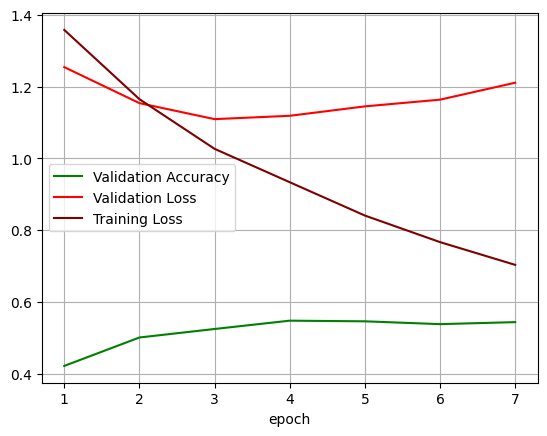

In [27]:
# Micro Average
model_dir = "../../models/multi_micro_stance_classifier/"
plot_metrics(model_dir)

In [28]:
multi_micro_preds = pd.read_csv('../../predictions/multi_micro_preds.csv')
multi_micro_acc = compute_accuracy(multi_micro_preds, 'numerical_label', 'prediction')

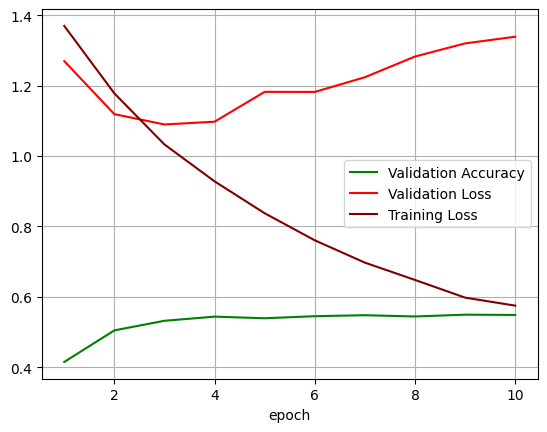

In [29]:
# Macro Average
model_dir = "../../models/multi_macro_stance_classifier/"
plot_metrics(model_dir)

In [30]:
multi_macro_preds = pd.read_csv('../../predictions/multi_macro_preds.csv')
multi_macro_acc = compute_accuracy(multi_macro_preds, 'numerical_label', 'prediction')

In [31]:
# All accuracies

multi_acc = reduce(lambda left, right: pd.merge(left, right, on='language'), [
    multi_base_acc.rename(columns={'accuracy': 'baseline'}),
    multi_micro_acc.rename(columns={'accuracy': 'finetuned_MicroAvg'}),
    multi_macro_acc.rename(columns={'accuracy': 'finetuned_MacroAvg'})
])
multi_acc

,language,baseline,finetuned_MicroAvg,finetuned_MacroAvg
0,de,0.282062,0.503574,0.494660
1,fr,0.304945,0.543040,0.523352
2,it,0.269018,0.508299,0.499308
